# An AutoEncoder for MNIST

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from tqdm import tqdm, trange
from sklearn.manifold import TSNE
from torch.utils.data import DataLoader
from torch.optim import Adam
from torchvision.datasets import MNIST
from torchvision.transforms.v2 import ToTensor, Normalize, Compose, ToImage, ToDtype

## Load MNIST Data

In [3]:
transform = Compose([
    # formerly used ToTensor, which is decaprecated now
    # transforms images to torchvision.tv_tensors_Image
    ToImage(),
    # with scale=True, scales pixel intensities from [0,255] to [0.0,1.0]
    ToDtype(torch.float32, scale=True),
    # could normalize the pixel intensity value to overall mean and std of train set
    # Normalize([0.1307], [0.3081]),
])

train_ds = MNIST("data/", train=True, download=True, transform=transform)
test_ds = MNIST("data/", train=False, download=True, transform=transform)

To access images, use `train_ds[i][0]` to get the transformed and scaled version.
Don't use `train_ds.data[i]`, unless you want the raw image.

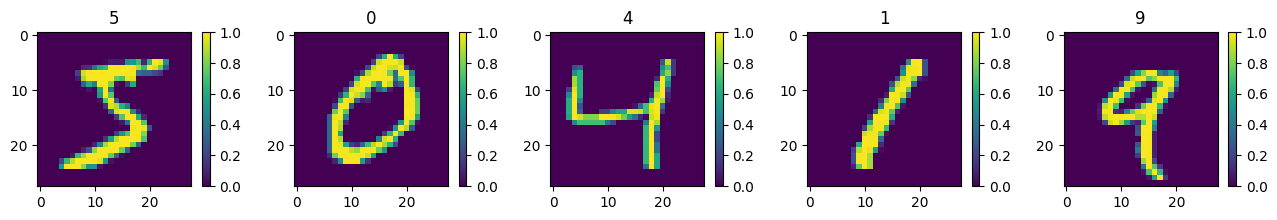

In [4]:
plt.figure(figsize=(16,2))

for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(train_ds[i][0].numpy().squeeze())
    plt.title(train_ds[i][1])
    plt.colorbar()

## t-SNE embedding

In [5]:
# subset size for t-sne
n_tsne = 1_000

labels = train_ds.targets[:n_tsne].numpy()
X = torch.stack([train_ds[i][0] for i in range(n_tsne)]).flatten(start_dim=1).numpy()
X.shape

(1000, 784)

In [6]:
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X)

In [7]:
tsne_df = pd.DataFrame({
    "tsne_1": X_tsne[:, 0],
    "tsne_2": X_tsne[:, 1],
    "label": labels.astype(str)
})

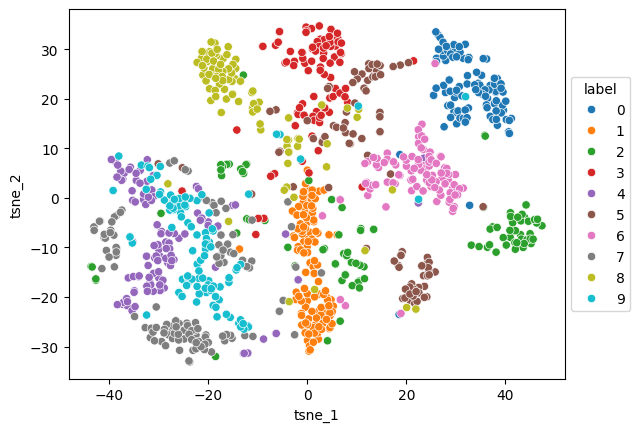

In [8]:
ax = sns.scatterplot(tsne_df.sort_values("label"), x="tsne_1", y="tsne_2", hue="label")
sns.move_legend(ax, "center left", bbox_to_anchor=(1, 0.5))

## Let's build a sparse convolutional AutoEncoder!

In [135]:
class Encoder(nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.conv = nn.Sequential(
            # shape: (N,1,28,28)
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(5,5), padding=2),
            # shape: (N,8,28,28)
            nn.MaxPool2d((2,2)),
            # shape: (N,8,14,14)
            # batch norms will help to stabilize and speed up training
            nn.BatchNorm2d(8),
            nn.ReLU(),
            # shape: (N,8,14,14)
            nn.Conv2d(in_channels=8, out_channels=8, kernel_size=(5,5), padding=2),
            # shape: (N,8,14,14)
            nn.MaxPool2d((2,2)),
            nn.BatchNorm2d(8),
            # shape: (N,8,7,7)
            nn.ReLU(),
            # shape: (N,8,7,7)
            # nn.Flatten(),
        )
        
        self.linear = nn.Sequential(
            # shape: (N,392)
            nn.Linear(392, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Linear(64, 10),
            # apply a softmax function
            # basically turning this into a one hot encoded vector
            nn.Softmax(dim=1) 
        )
 
    def forward(self, x: torch.Tensor):
        x = self.conv(x)
        x = x.flatten(start_dim=1)
        x = self.linear(x)
        return x

In [136]:
class Decoder(nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.linear = nn.Sequential(
            nn.Linear(10, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Linear(64, 392),
            nn.BatchNorm1d(392),
            nn.ReLU(),
            # nn.Unflatten(dim=1, unflattened_size=(8,8,7))
        )

        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(8, 8, (5,5), padding=2, stride=2, output_padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            # output_padding does not actually add 0s around the output, just increases the size
            nn.ConvTranspose2d(8, 1, (5,5), padding=2, stride=2, output_padding=1),
            # apply sigmoid to map to [0,1]
            nn.Sigmoid()
        )
    
    def forward(self, x: torch.Tensor):
        # input shape (N, 10)
        x = self.linear(x)
        # reshape x to the right dimensions
        x = x.unflatten(1, (8,7,7))
        # transposed convolution
        x = self.deconv(x)
        return x

In [137]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
    
    def forward(self, x):
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat, z

## Training Time!

In [138]:
# wrap our train and test datasets in a DataLoader
# will automatically group samples in batches for training
train_dl = DataLoader(train_ds, batch_size=32, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=32)

In [ ]:
def train(model, train_dl, n_epochs, lambda_l1=1, lambda_ent=1, log_interval=100):
    """Train an autoencoder to reproduce the input."""
    model.train()
    criterion = nn.MSELoss()
    loss_log = []
    optimizer = Adam(model.parameters(), lr=1e-4)
    l1 = nn.L1Loss()

    step = 0
    for epoch in trange(n_epochs):
        for x, _ in train_dl:
            x_hat, z = model(x)
            loss = criterion(x_hat, x)
            # add l1 loss to enforce sparsity in latent representation
            # loss += lambda_l1 * l1(z, torch.zeros_like(z))
            # add entropy loss term to encourage latent representations with small entropy
            # i.e., one hot like encodings
            entropy = -1 * torch.sum(z * torch.log(z), dim=1).mean()
            loss += lambda_ent * entropy

            if step % log_interval == 0:
                loss_log.append(loss.item())
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            step += 1
    
    return loss_log

In [176]:
# hyper-parameters to play around with
EPOCHS = 30
# LAMBDA_L1 = 1e-1
LAMDA_ENT = 1e-2

In [177]:
model = AutoEncoder()

loss_log = train(model, train_dl, EPOCHS, lambda_ent=LAMDA_ENT)

100%|██████████| 30/30 [22:55<00:00, 45.86s/it]


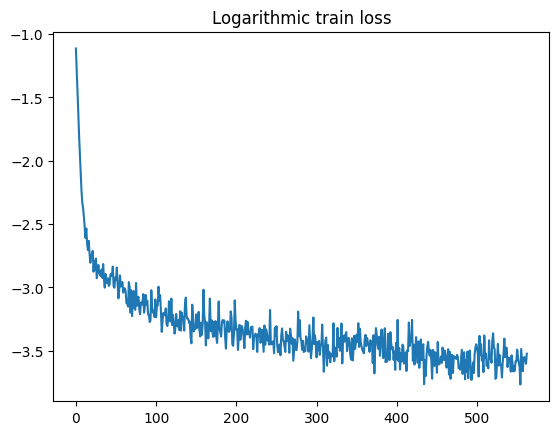

In [178]:
plt.plot(np.log(loss_log))
plt.title("Logarithmic train loss");

## Can our AutoEncoder reconstruct the input images?

In [179]:
# switch model from train to test (eval) mode
model.eval()

AutoEncoder(
  (encoder): Encoder(
    (conv): Sequential(
      (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
      (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): ReLU()
      (4): Conv2d(8, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (5): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
      (6): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (7): ReLU()
    )
    (linear): Sequential(
      (0): Linear(in_features=392, out_features=64, bias=True)
      (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Linear(in_features=64, out_features=10, bias=True)
      (4): Softmax(dim=1)
    )
  )
  (decoder): Decoder(
    (linear): Sequential(
      (0): Linear(in_features=10,

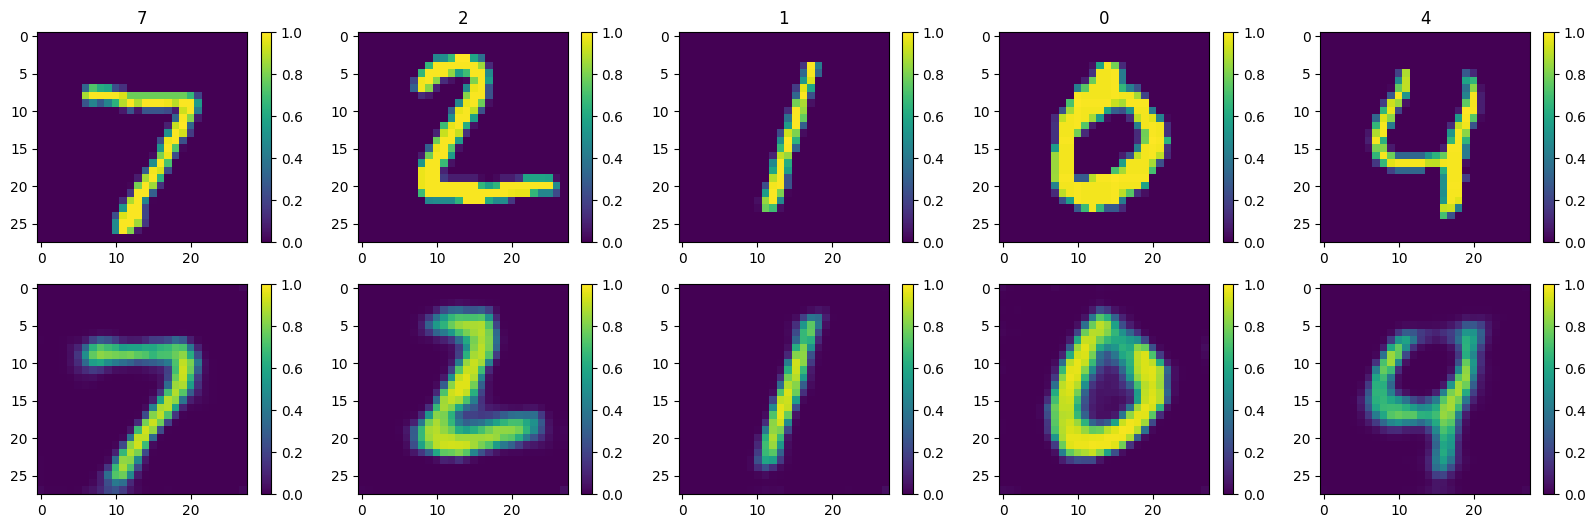

In [180]:
x_test = torch.stack([test_ds[i][0] for i in range(5)])
y_test = [test_ds[i][1] for i in range(5)]

model.eval()
with torch.no_grad():
    x_hat, _ = model(x_test)

plt.figure(figsize=(20,6))

for i in range(5):
    plt.subplot(2, 5, i+1)
    plt.imshow(x_test[i].numpy().squeeze(), vmin=0, vmax=1)
    plt.title(y_test[i])
    plt.colorbar()

    plt.subplot(2, 5, i+1+5)
    plt.imshow(x_hat[i].numpy().squeeze(), vmin=0, vmax=1)
    plt.colorbar()

plt.show()

## Latent Representations

- softmax alone is not enough to enfource discrete, one-hot like latent representations
    - could implement softmax with temperature
    - or extent loss function with penalty term for l1 norm or entropy of latent representation
    - or cheat gradients with a straight through operator
- playing around with the temperature actually influences if latent representations are sparse or not!

In [183]:
model.eval()

n_test = 1_000

x_test = torch.stack([test_ds[i][0] for i in range(n_test)])
y_test = torch.tensor([test_ds[i][1] for i in range(n_test)])

with torch.no_grad():
    x_hat, z_test = model(x_test)

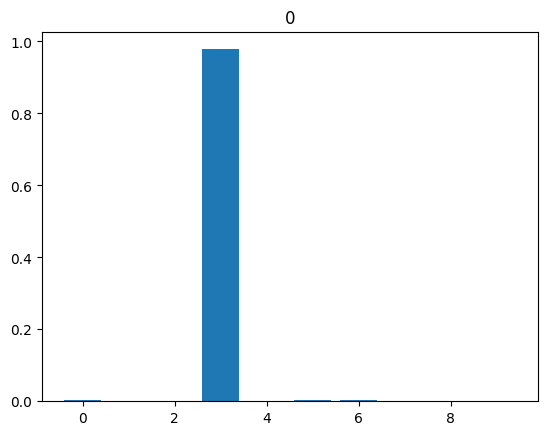

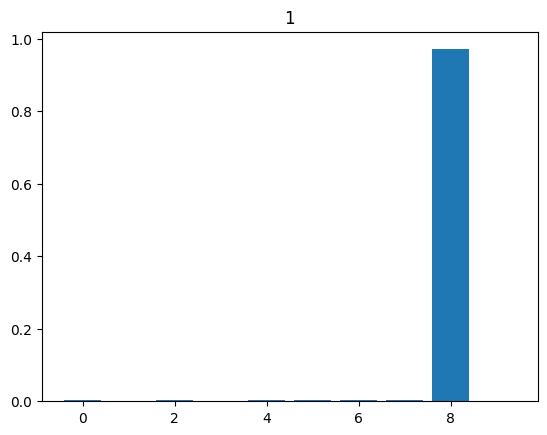

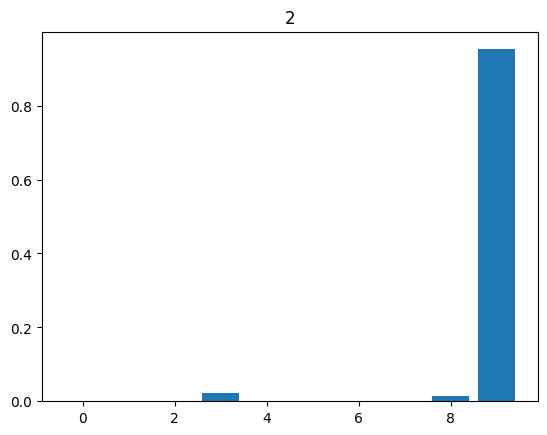

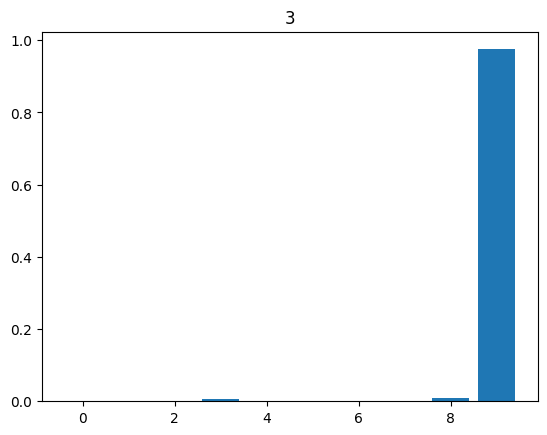

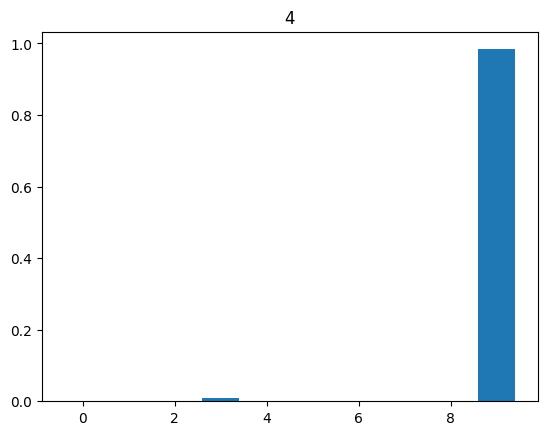

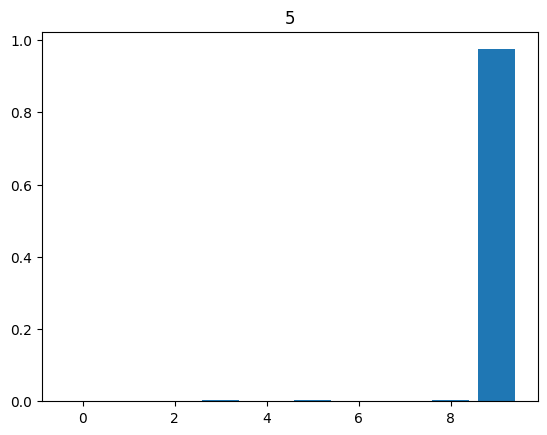

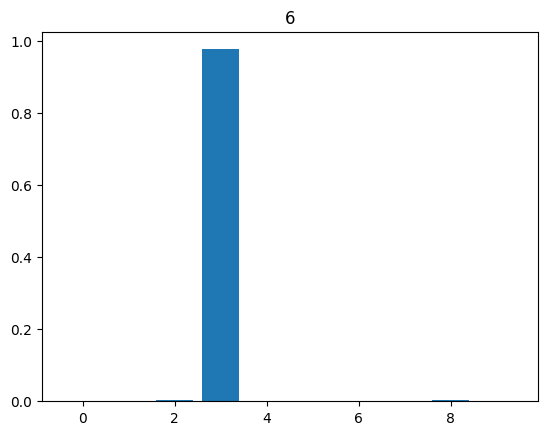

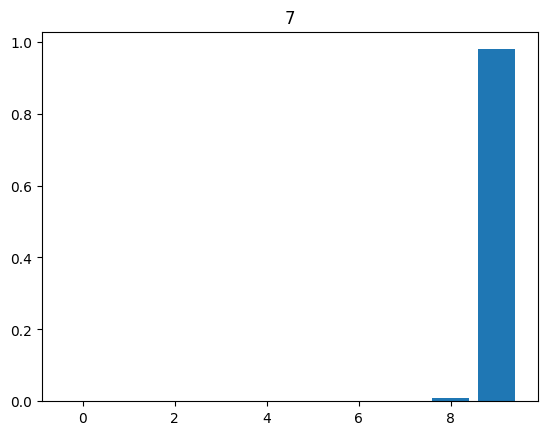

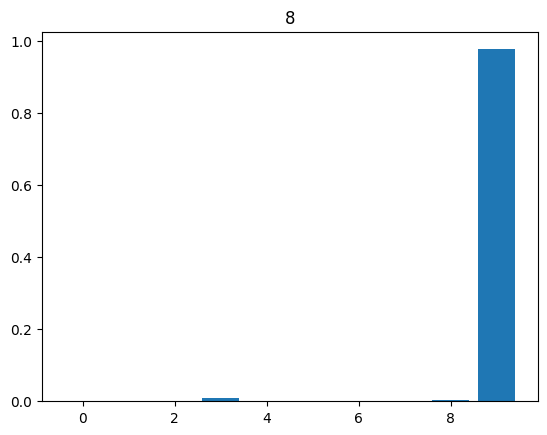

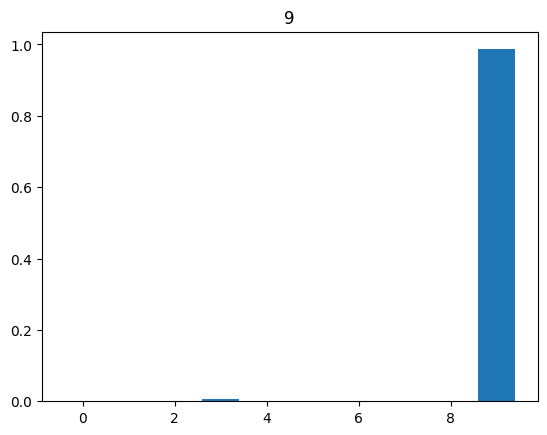

In [184]:
# visualize median latent representations
for i in range(10):
    m,_ = z_test[y_test == i].median(dim=0)
    plt.bar(np.arange(10), m.numpy())
    plt.title(i)
    plt.show()

In [185]:
latent_df = pd.DataFrame(z_test, columns=[f"dim_{i}" for i in range(10)])
latent_df["label"] = y_test

latent_df.head()

,dim_0,dim_1,dim_2,dim_3,dim_4,dim_5,dim_6,dim_7,dim_8,dim_9,label
0,0.001236,0.000488,0.001381,0.000353,0.000890,0.000722,0.002158,0.002722,0.007335,0.982715,7
1,0.000826,0.000929,0.001212,0.055387,0.000563,0.001626,0.000544,0.000176,0.064718,0.874020,2
2,0.002831,0.001123,0.002537,0.000834,0.002575,0.002840,0.003288,0.002563,0.981289,0.000120,1
3,0.001600,0.001267,0.002183,0.986634,0.000710,0.002056,0.002294,0.002570,0.000160,0.000528,0
4,0.001250,0.000952,0.000814,0.008082,0.001769,0.000201,0.001149,0.000680,0.000169,0.984934,4


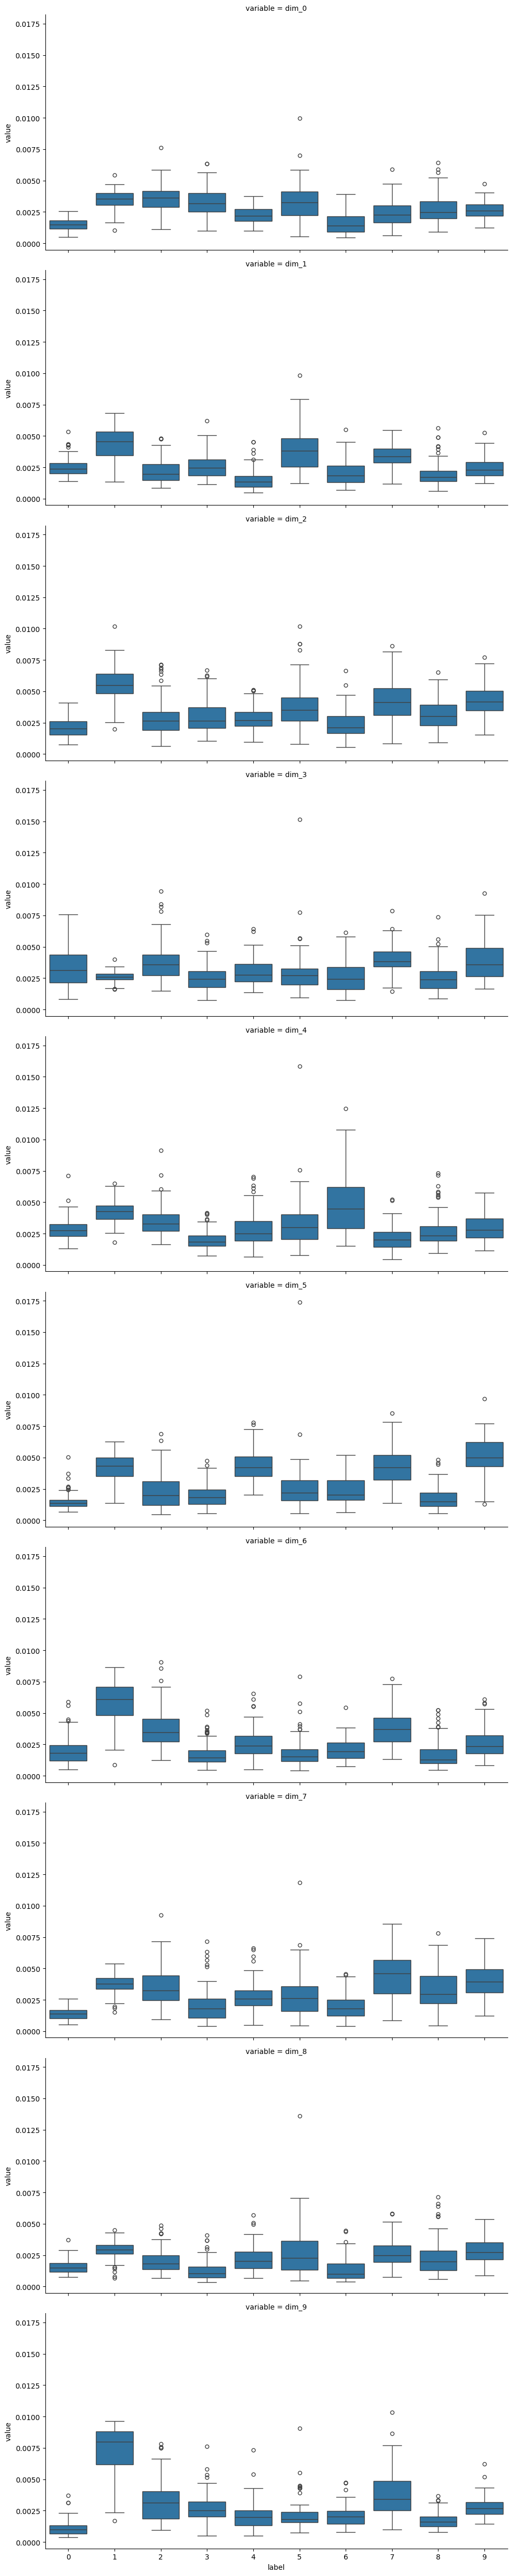

In [132]:
# visualize values of latent dims for each class
sns.catplot(latent_df.melt(id_vars="label"), row="variable", x="label", y="value", kind="box", aspect=2)

In [133]:
latent_tsne = TSNE()

z_tsne = latent_tsne.fit_transform(z_test)

z_tsne_df = pd.DataFrame({
    "tsne_1": z_tsne[:, 0],
    "tsne_2": z_tsne[:, 1],
    "label": y_test.numpy().astype(str)
})

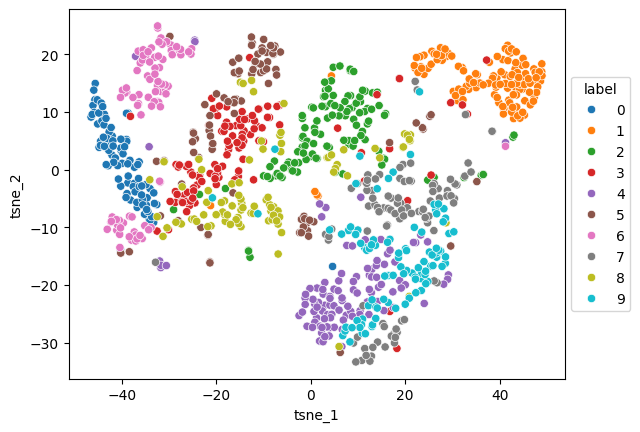

In [134]:
ax = sns.scatterplot(z_tsne_df.sort_values("label"), x="tsne_1", y="tsne_2", hue="label")
sns.move_legend(ax, "center left", bbox_to_anchor=(1,0.5))